# 2장 머신러닝 프로젝트 처음부터 끝까지



## 주요 내용

* 회귀 모델 소개
* 회귀 모델 성능 평가 방법 소개
* 실전 예제: 미국 캘리포니아 주 구역별 통계 조사를 이용한 주택 가격 예측 모델 훈련

__참고:__
핵심 설명과 코드는 &#x1f511;로 표시되었으며 굳이 알아둘 필요가 없는 코드는 &#x270b;로 표시되었다.

## 기본 설정

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [18]:
# 파이썬 ≥3.5
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림 저장 위치 지정
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 1부

## 2.3 데이터 가져오기 (p. 75)

### 2.3.2 데이터 다운로드 (p. 79)

* 온라인 상에 저장된 압축파일을 가져오기
* 압축파일을 풀어 csv 파일로 저장

In [19]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/codingalzi/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "notebooks/datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [20]:
fetch_housing_data()

/tmp/ipython-input-26603407.py:15: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tgz.extractall(path=housing_path)


### 2.3.3 데이터 구조 훑어보기 (p. 81)

* csv 파일을 판다스 데이터프레임으로 불러오기

In [21]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [22]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


* 데이터셋 기본 정보 확인하기

In [23]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* 범주형 특성 탐색

In [24]:
housing["ocean_proximity"].value_counts()

,count
ocean_proximity,
<1H OCEAN,9136
INLAND,6551
NEAR OCEAN,2658
NEAR BAY,2290
ISLAND,5


* 수치형 특성 탐색

In [25]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


* 수치형 특성별 히스토그램

그림 저장: attribute_histogram_plots


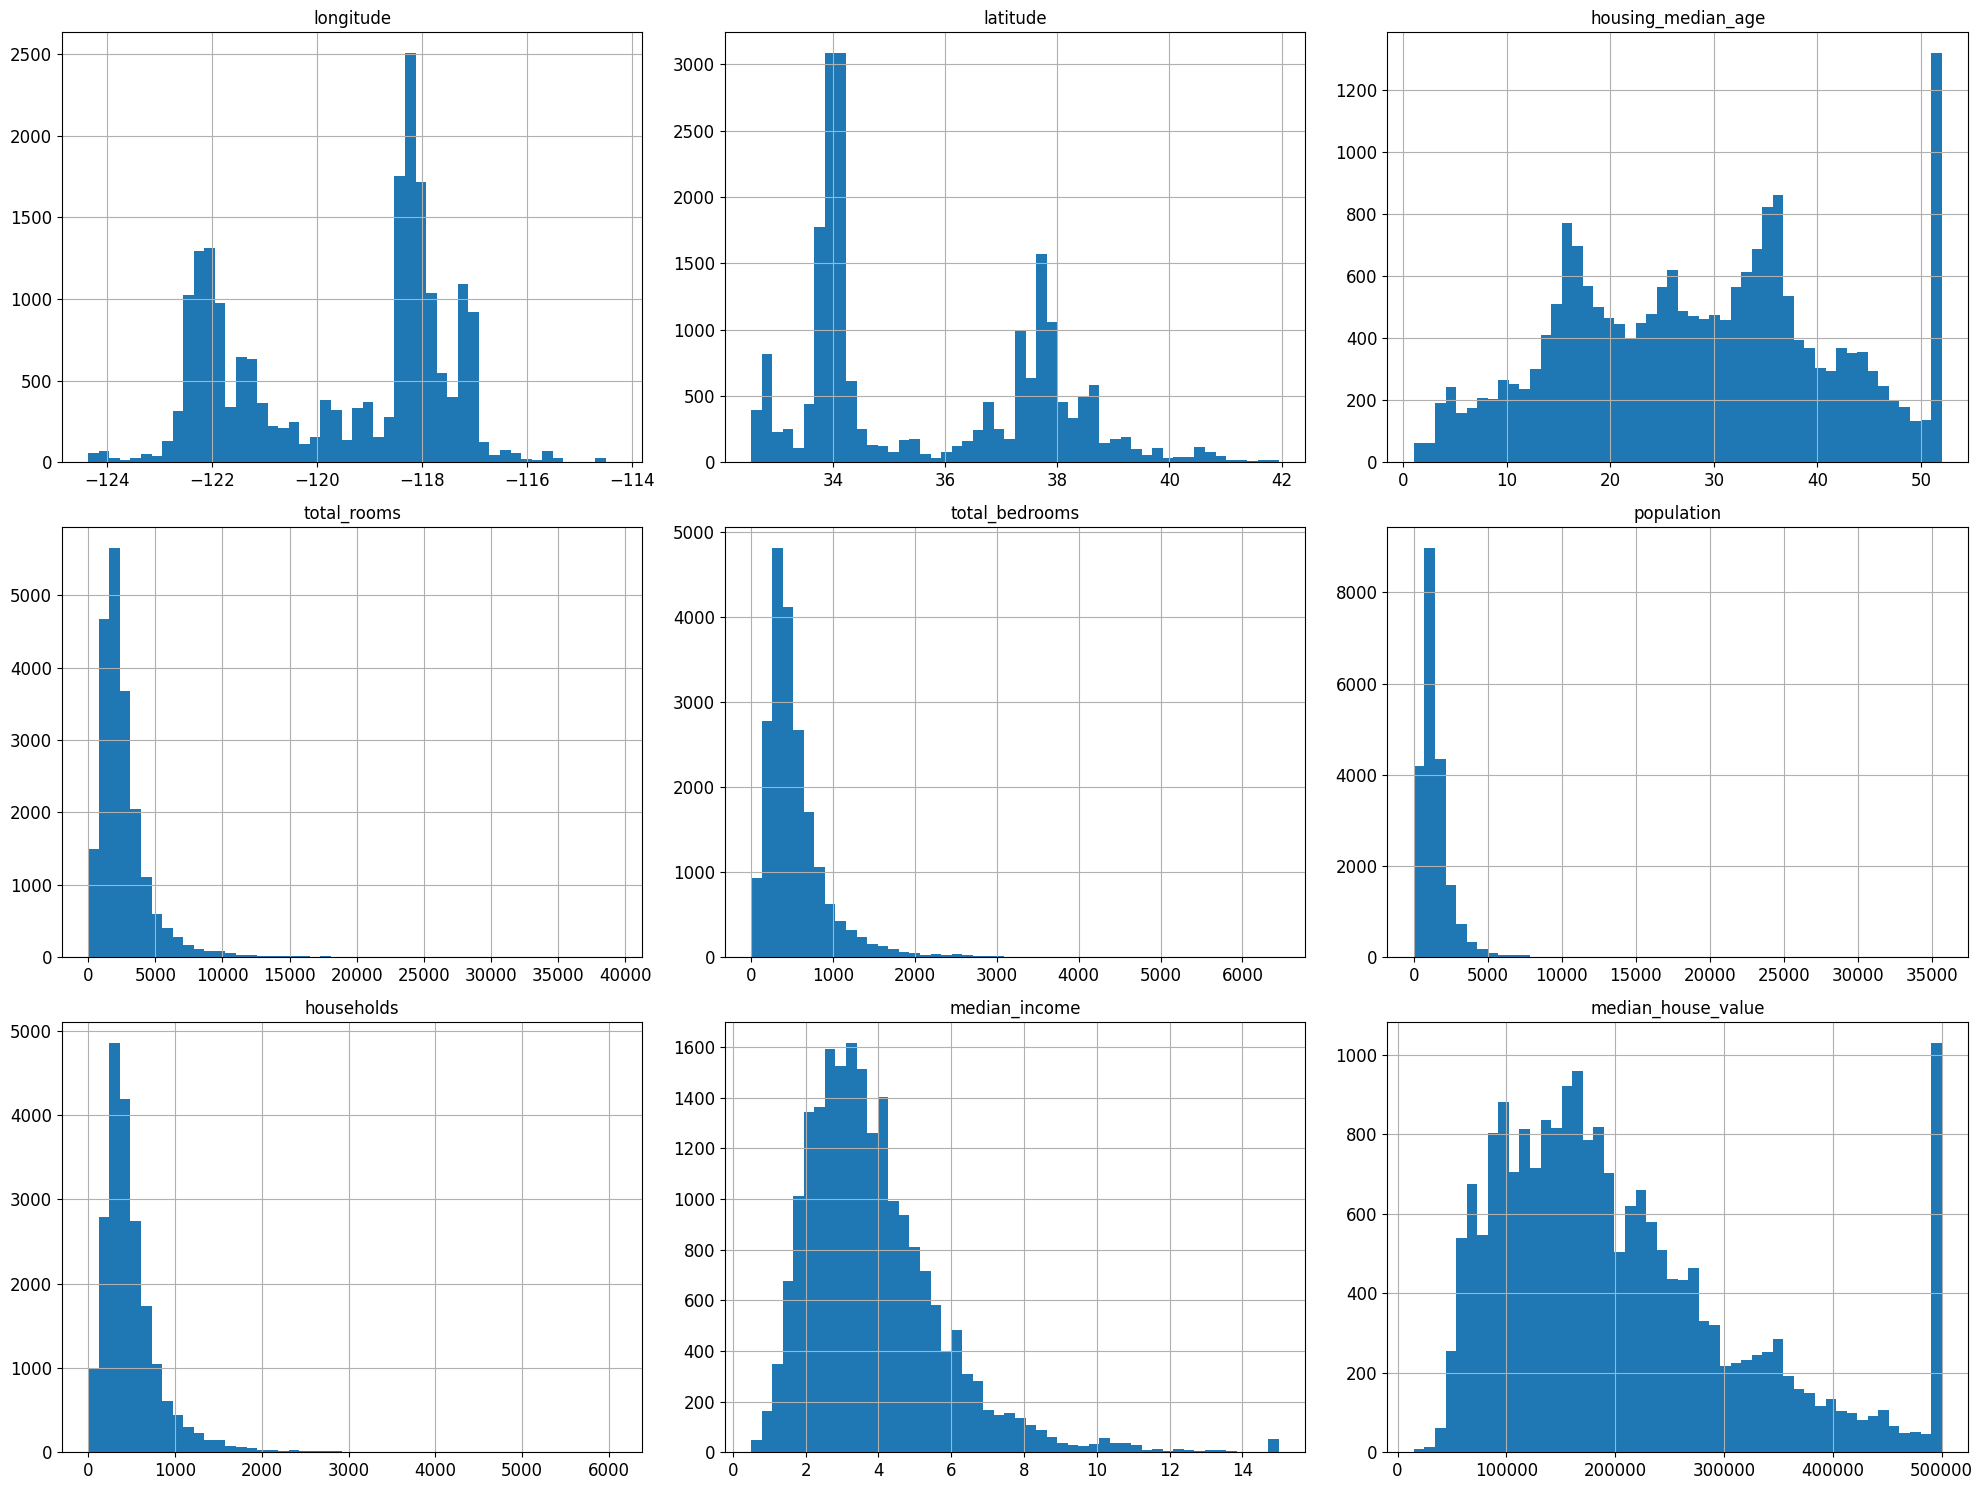

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

### 2.3.4 테스트 세트 만들기 (p. 85)

In [27]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

#### 무작위 샘플링 (p. 85)

* 훈련 세트와 테스트 세트 구분(연습용)

In [28]:
import numpy as np

# 예시 용도로 만든 훈련 세트/테스트 세트 분류 함수. 실전용 아님.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [29]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [30]:
len(test_set)

4128

* 테스트 세트의 비율은 20%

In [31]:
len(test_set) / len(housing)

0.2

* 문제점
    - 실행할 때마다 완전히 새로 샘플링함
    - 따라서 반복 훈련을 진행 할 경우 테스트 세트가 모델에 노출됨.
    - 해결책: 샘플 고유의 식별자를 활용하여 식별자를 기준으로 훈련세트와 테스트 세트 구분

* &#x270b; `split_train_test_by_id()` 함수
    * 식별자의 체크섬을 기준으로 체크섬 값이 일정 백분율 이하인
        샘플을 테스트 세트에 저장
    - 체크섬(checksum): 파일 전송 과정에서 발생할 수 있는 손실 여부를 판단하기 위해 사용되는 값으로
        파일이 달라지면 체크섬 값이 달라짐.
        - 참고: [위키백과: 체크섬](https://ko.wikipedia.org/wiki/체크섬)
    - `zlib.crc32()` 함수: 파일의 체크섬을 CRC 방식으로 계산한 32비트 정수 반환
        - CRC(순환 중복 검사): 파일의 체크섬을 계산하는 방식
        - `0xffffffff`: 32비트 정수 중에서 가장 큰 정수, 즉 `2**32 - 1`.
        - `test_ratio * 2**32`: 32비트 정수 중에서 `test_ratio` 비율에 해당하는 정수
            예를 들어, `test_ratio = 0.2` 이며, 하위 20%에 해당하는 정수.
    - `&`: __이진 논리곱__(binary AND)이라는 비트 연산자.
        - 이진법으로 표현된 두 숫자의 논리곱 연산자
        - 동일한 위치의 수가 둘 모두 1일 때만 1로 계산됨.
        - 여기서는 `0xffffffff`와의 비트 연산을 통해 `2**32` 보다 작은 값으로 제한하기 위해 사용됨.
            하지만 `zlib.crc32()` 함수가 32비트 정수를 반환하기에 굳이 사용할 필요 없음.
    - 참고: [위키독스: 비트 연산자](https://wikidocs.net/20704)

In [32]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

* 고유 식별자 생성법 1: 인덱스 활용

In [33]:
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임 반환
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

* 고유 식별자 생성법 2: 경도와 위도 활용

In [34]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [35]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


* 사이킷런의 무작위 샘플링 함수

In [36]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [37]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


* 무작위 샘플링의 단점
    - 계층별 특성을 고려하지 못함

#### 계층별 샘플링 (p. 88)

* 전체 데이터셋의 중간 소득 히스토그램

<Axes: >

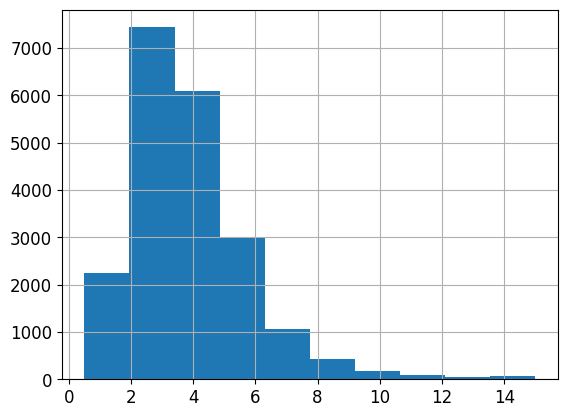

In [38]:
housing["median_income"].hist()

* 대부분 구역의 중간 소득이 **1.5~6.0**(15,000~60,000&#x24;) 사이

* 소득 구간을 아래 숫자를 기준으로 5개로 구분

    ```python
    [0, 1.5, 3.0, 4.6, 6.0, np,inf]
    ```

* 5개의 카테고리를 갖는 특성 추가
    - 특성값: 1, 2, 3, 4, 5

In [39]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

* 계층(소득 구간) 특성 히스토그램

In [40]:
housing["income_cat"].value_counts()

,count
income_cat,
3,7236
2,6581
4,3639
5,2362
1,822


<Axes: >

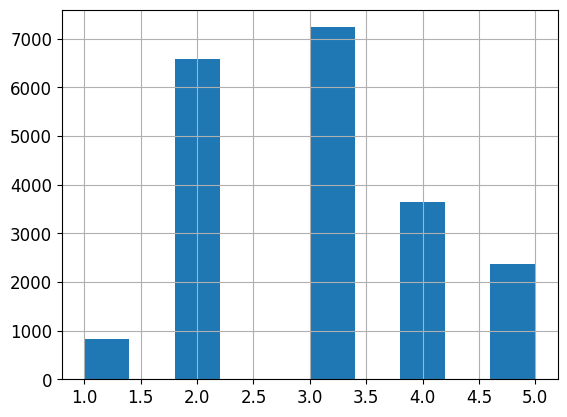

In [41]:
housing["income_cat"].hist()

* 계층별 샘플링 실행
    - `housing["income_cat"]` 기준

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

* 소득 계층 비율이 유지되었음을 확인 가능

In [43]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

,count
income_cat,
3,0.350533
2,0.318798
4,0.176357
5,0.114341
1,0.039971


In [44]:
housing["income_cat"].value_counts() / len(housing)

,count
income_cat,
3,0.350581
2,0.318847
4,0.176308
5,0.114438
1,0.039826


* 무작위 샘플림 대 계층별 샘플링 결과 비교

In [45]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [46]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
income_cat,,,,,
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


* 데이터 되돌리기
    - `income_cat` 특성 삭제
    - 이제 본격적으로 학습 시작할 것임

In [47]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## 2.4 데이터 이해를 위한 탐색과 시각화 (p. 91)

훈련세트 원본을 그대로 두고 복사해서 사용한다.
- 훈련세트만을 대상으로 탐색과 시각화 적용
- 데이터 스누핑 편향 방지 용도

In [48]:
housing = strat_train_set.copy()

### 2.4.1 지리적 데이터 시각화 (p. 91)

그림 저장: bad_visualization_plot


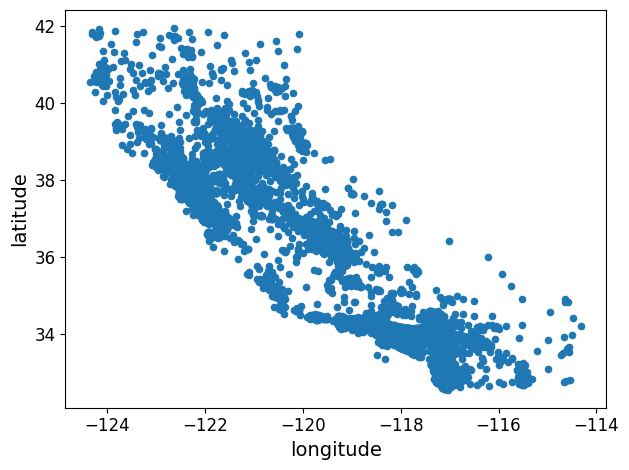

In [49]:
housing.plot(kind="scatter", x="longitude", y="latitude")
save_fig("bad_visualization_plot")

* `alpha` 키워드 인자 활용
    - 구역이 밀집되어 모여있는 정도를 보다 선명하게 보여줌.

그림 저장: better_visualization_plot


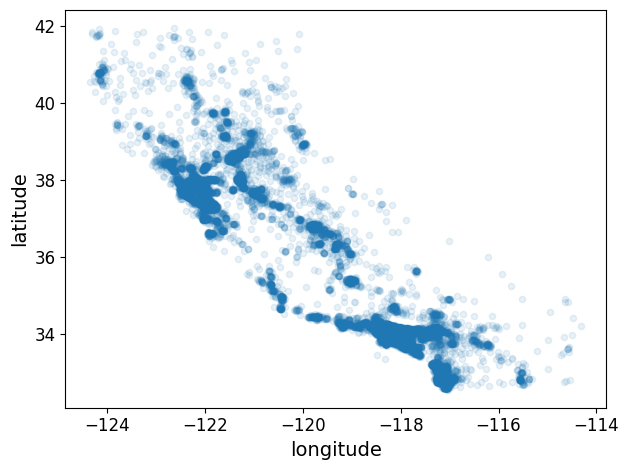

In [50]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
save_fig("better_visualization_plot")

* `sharex=False` : x-축의 값과 범례를 표시하지 못하는 버그 수정 용도이며 임시 방편 해결책임
    - 참고: https://github.com/pandas-dev/pandas/issues/10611

그림 저장: housing_prices_scatterplot


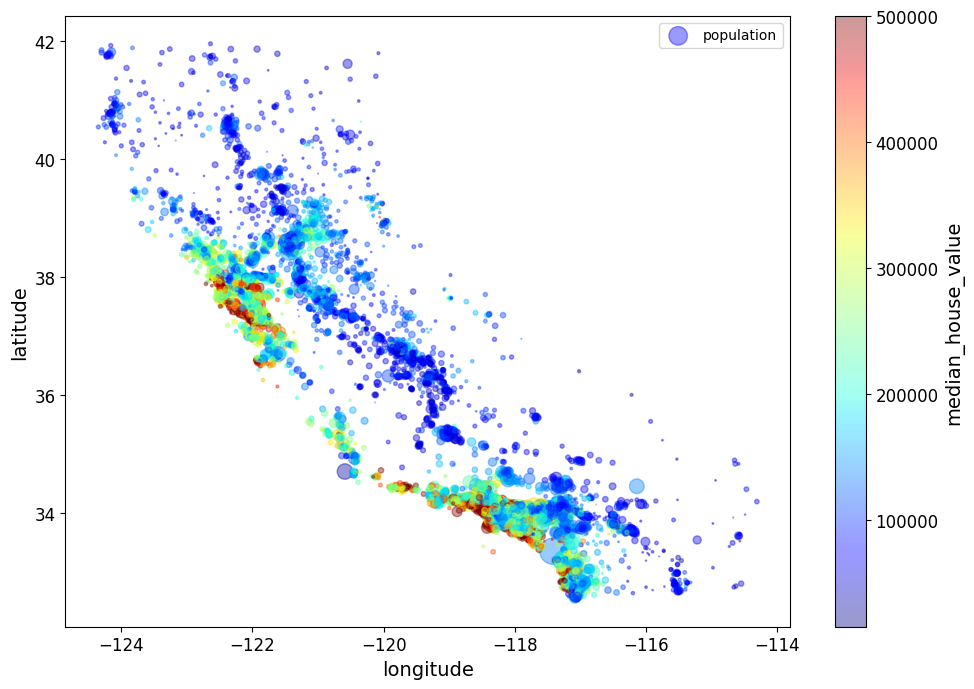

In [51]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()
save_fig("housing_prices_scatterplot")

* 캘리포니아 지도와 합치기

In [52]:
# 캘리포니아 지도 다운로드
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x785dc0b0f3b0>)

그림 저장: california_housing_prices_plot


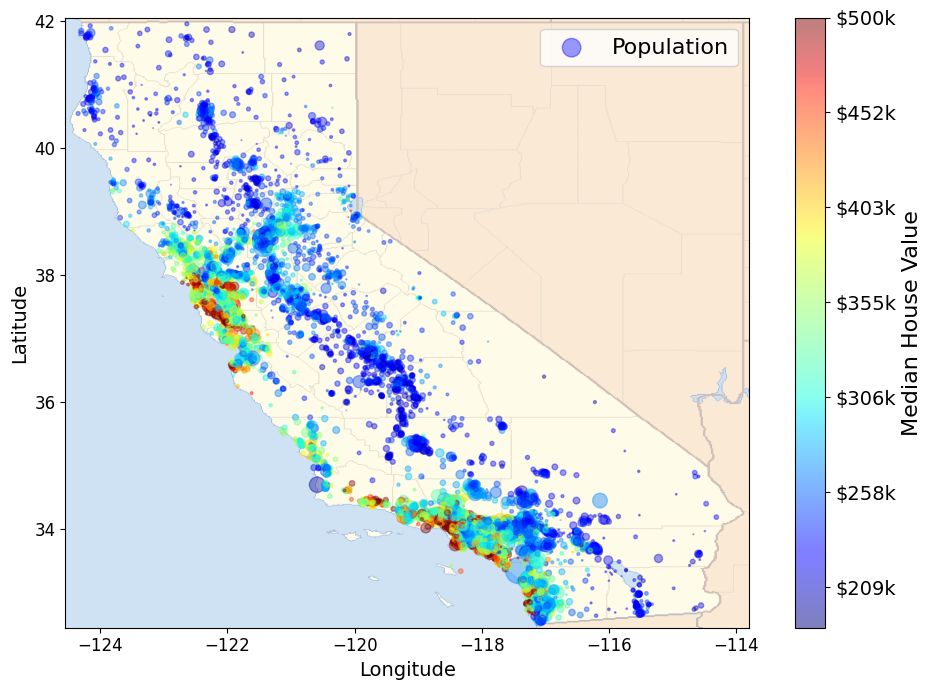

In [53]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                  s=housing['population']/100, label="Population",
                  c="median_house_value", cmap=plt.get_cmap("jet"),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

### 2.4.2 상관관계 조사 (p. 94)

* 모든 수치형 특성 간의 표준 상관계수 계산

In [54]:
corr_matrix = housing.corr(numeric_only=True)

* 중간 주택 가격과 다른 특성 간의 상관관계 확인

In [55]:
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population,-0.026882
longitude,-0.047466
latitude,-0.142673


* 피어슨의 상관계수
    * 상관계수: $[-1, 1]$ 구간의 값
    * 1에 가까울 수록: 강한 양의 선형 상관관계
    * -1에 가까울 수록: 강한 음의 선형 상관관계
    * 0에 가까울 수록: 매우 약한 선형 상관관계

![Pearson correlation coefficient](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

<그림 출처: [위키백과](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)>

* 특성들 사이의 상관관계를 나타내는 산점도

그림 저장: scatter_matrix_plot


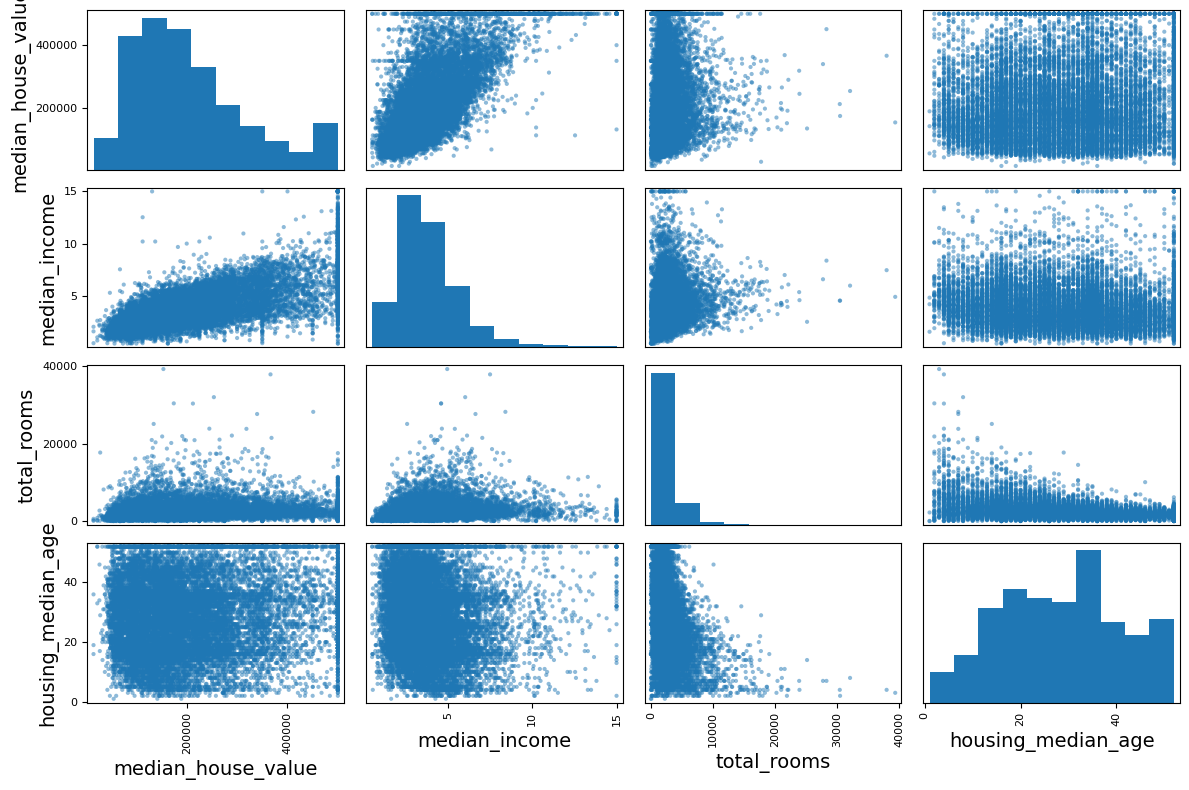

In [56]:
# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")

* 중간 소득 대 중간 주택 가격 산점도

그림 저장: income_vs_house_value_scatterplot


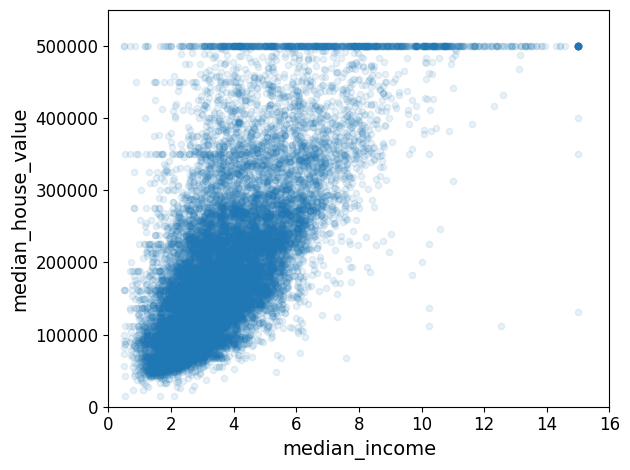

In [57]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
save_fig("income_vs_house_value_scatterplot")

* 특징
    * 점들이 너무 넓게 퍼져 있음. 완벽한 선형관계와 거리 멂.
    * 50만 달러 수평선: 가격 제한
        * 45만, 35만, 28만, 그 아래 정도에서도 수평선 존재
        * 이상한 형태를 학습하지 않도록 해당 구역을 제거하는 것이 좋음.

### 2.4.3 특성 조합으로 실험 (p. 97)

구역별 방의 총 개수와 침실의 총 개수 대신 아래 특성이 보다 유용하다.
- 가구당 방의 개수
- 방당 침실 개수
- 가구당 인원 수

In [58]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

* 상관관계 다시 확인

In [59]:
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

,median_house_value
median_house_value,1.000000
median_income,0.687151
rooms_per_household,0.146255
total_rooms,0.135140
housing_median_age,0.114146
households,0.064590
total_bedrooms,0.047781
population_per_household,-0.021991
population,-0.026882
longitude,-0.047466


가구당 방 개수의 역할은 여전히 미미하다.

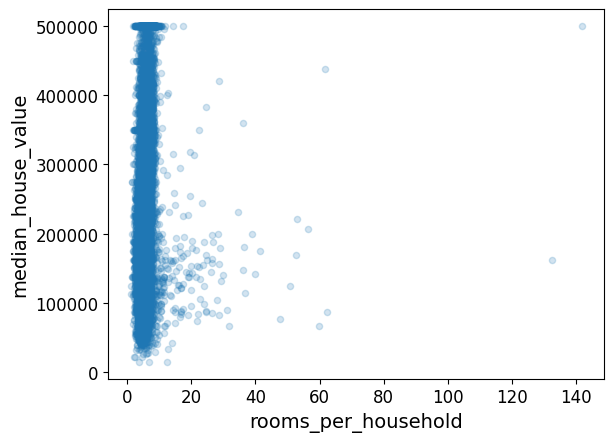

In [60]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.show()

* 전체 수치형 특성 다시 확인

In [61]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_household,bedrooms_per_room,population_per_household
count,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16354.000000,16512.000000
mean,-119.575635,35.639314,28.653404,2622.539789,534.914639,1419.687379,497.011810,3.875884,207005.322372,5.440406,0.212873,3.096469
std,2.001828,2.137963,12.574819,2138.417080,412.665649,1115.663036,375.696156,1.904931,115701.297250,2.611696,0.057378,11.584825
min,-124.350000,32.540000,1.000000,6.000000,2.000000,3.000000,2.000000,0.499900,14999.000000,1.130435,0.100000,0.692308
25%,-121.800000,33.940000,18.000000,1443.000000,295.000000,784.000000,279.000000,2.566950,119800.000000,4.442168,0.175304,2.431352
50%,-118.510000,34.260000,29.000000,2119.000000,433.000000,1164.000000,408.000000,3.541550,179500.000000,5.232342,0.203027,2.817661
75%,-118.010000,37.720000,37.000000,3141.000000,644.000000,1719.000000,602.000000,4.745325,263900.000000,6.056361,0.239816,3.281420
max,-114.310000,41.950000,52.000000,39320.000000,6210.000000,35682.000000,5358.000000,15.000100,500001.000000,141.909091,1.000000,1243.333333


# 2부

## 2.5 머신러닝 알고리즘을 위한 데이터 준비 (p. 99)

훈련세트를 대상으로 중간 주택 가격을 타깃값(레이블)로 사용하기 위해 다른 특성으로 분리한다.

- `housing`: 훈련에 사용되는 특성 9개 (중간 주택 가격 제외)
- `housing_labels`: 중간 주택 가격

In [62]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 데이터 정제 (p. 99)

#### 수치형 특성 전처리 과정 1: `total_bedrooms` 특성에 존재하는 누락치 처리법 결정

- 누락치가 있는 샘플 데이터 확인하기

In [63]:
sample_incomplete_rows = housing[housing.isnull().any(axis=1)].head()
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,NaN,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,NaN,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,NaN,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,NaN,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,NaN,1145.0,480.0,6.3580,NEAR OCEAN


- 누락치 처리 방법 세 가지
    - 옵션 1: 누락치가 있는 샘플 삭제
    - 옵션 2: 누락치가 있는 특성 삭제
    - 옵션 3: 누락치를 특성 중앙값 등으로 채우기

In [64]:
sample_incomplete_rows.dropna(subset=["total_bedrooms"])    # 옵션 1

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity


In [65]:
sample_incomplete_rows.drop("total_bedrooms", axis=1)       # 옵션 2

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,1145.0,480.0,6.3580,NEAR OCEAN


In [66]:
median = housing["total_bedrooms"].median()
sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3

/tmp/ipython-input-15549382.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sample_incomplete_rows["total_bedrooms"].fillna(median, inplace=True) # 옵션 3


여기서는 옵션 3을 활용한다. 즉, 누락치를 특성 중앙값으로 채운다.

In [67]:
sample_incomplete_rows

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330,NEAR BAY
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193,<1H OCEAN
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813,<1H OCEAN
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891,<1H OCEAN
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580,NEAR OCEAN


##### `SimpleImputer` 변환기

`SimpleImputer` 변환기를 활용하면 옵션 3을 쉽게 처리할 수 있다.

In [68]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

중앙값이 수치형 특성에서만 계산될 수 있기 때문에 범주형 특성을 제거한 후에 `SimpleImputer` 변환기를 적용해야 한다.

In [69]:
housing_num = housing.drop("ocean_proximity", axis=1)
# 다른 방법: housing_num = housing.select_dtypes(include=[np.number])

`SimpleImputer` 변환기의 `fit()` 메서드는 지정된 통계 특성값을 계산하여 저장해 둔다.

* `statistics_` 속성에 저장됨.

In [70]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [71]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

각 특성의 중앙값이 수동으로 계산한 것과 동일하다.

In [72]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

`transform()` 메서드를 실행하여 수치형 특성을 변환한다.
- 반환값은 넘파이 어레이 자료형임.
- 팬다스의 데이터프레임으로 형변환시켜야 함.
    - `housing_tr`: 수치형 특성의 누락치가 채워진 (훈련) 데이터셋

In [73]:
X = imputer.transform(housing_num)

In [74]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

앞서 누락치를 수동으로 채운 결과와 동일함을 확인할 수 있다.

In [75]:
housing_tr.loc[sample_incomplete_rows.index.values]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
1606,-122.08,37.88,26.0,2947.0,433.0,825.0,626.0,2.9330
10915,-117.87,33.73,45.0,2264.0,433.0,1970.0,499.0,3.4193
19150,-122.70,38.35,14.0,2313.0,433.0,954.0,397.0,3.7813
4186,-118.23,34.13,48.0,1308.0,433.0,835.0,294.0,4.2891
16885,-122.40,37.58,26.0,3281.0,433.0,1145.0,480.0,6.3580


누락치를 채우는데 사용한 전략이 중앙값(median)임을 다시 확인할 수 있다.

In [76]:
imputer.strategy

'median'

In [77]:
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964


### 2.5.2 텍스트와 범주형 특성 다루기 (p.102)

#### 범주형 입력 특성인 `ocean_proximity` 전처리 하기: 원-핫 인코딩 활용

해안 근접도(`ocean_proximity`) 다시 확인

In [78]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


범주형 특성값을 단순하게 수치화하면 다음과 같다.

In [79]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

수치화된 번호는 범주들의 인덱스에 해당한다.
하지만 숫자의 크기가 모델 훈련 과정에 잘못된 영향을 줄 수 있음에 주의해야 한다.

In [80]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

따라서 여기서는 대신에 원-핫-인코딩을 활용한다.

- 범주 수 만큼의 새로운 특성 추가
- 해당되는 범주와 관련된 특성값은 1, 나머지 특성값은 0.

In [81]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

#### `OneHotEncoder` 변환기
- 기본적으로 희소 행렬 반환
- `toarray()` 메서드: 희소 행렬을 밀집 배열로 변환

In [82]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

`OneHotEncoder` 변환기의 `sparse=False` 하이퍼파라미터로 지정하면 밀집 행렬이 생성된다.

In [83]:
cat_encoder = OneHotEncoder(sparse_output=False)
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

사용된 범주 어레이는 `categories_` 속성에 저장된다.

In [84]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### 2.5.3 나만의 변환기 (p.105)

#### 수치형 특성 전처리 과정 2: 특성 추가

직접 변환기를 구현해야 한다.
- `__init__()` 메서드: 방당 침실수 특성을 추가여부 지정 키워드 인자 활용. (연습을 위해 일부러 키워드 인자로 지정하였음.)
- `fit()`과 `transform()` 메서드를 갖는 클래스 선언
    - `fit()` 메서드: 아무 것도 하지 않고 `self` 리턴. 즉, 아무런 값도 추정할 필요 없음.
    - `transform()` 메서드: 속성 추가 기능 구현해야 함
        - `np.c_()` 함수: 두 어레이를 열을 축으로 해서 이어 붙이기
    - 두 메서드의 인자는 모두 넘파이 어레이이어야 함.
- `BaseEstimator` 클래스와 `TransformerMixin` 클래스 상속
    - `BaseEstimator` 클래스 상속: 하이퍼파라미터 튜닝에 필요한 `get_params()`, `set_params()` 메서드 자동 구현.
    단, 초기 설정 메서드(`__init__()`)가 `*args` 또는 `kargs` 형식의 인자를 사용하지 않아야 함.
    - `TransformerMixin` 클래스 상속: `fit_transform()` 메서드 자동 구현

In [85]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # *args 또는 **kargs 없으며, 키워드 인자 활용함.
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않음
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False) # 연습 용도로 방당 침실수를 추가하지 않음
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

특성 추가에 사용되는 기본의 특성들의 인덱스를 (3, 4, 5, 6) 처럼 수동으로 지정하는 것 대신에 아래와 같이 동적으로 처리하는 게 보다 좋다.
- `get_loc()` 메서드 활용

In [86]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    housing.columns.get_loc(c) for c in col_names] # 열 인덱스 구하기

`housing_extra_attribs`는 넘파이 어레이이며,
따라서 기존에 사용된 `columns`와 `index`를 이용하여 `DataFrame`으로 복원해야 한다.

In [87]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,INLAND,5.485836,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,NEAR OCEAN,6.927083,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.875,INLAND,5.393333,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,NEAR OCEAN,3.886128,1.859213
20496,-118.7,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,<1H OCEAN,6.096552,3.167241


### 2.5.4 특성의 축척 조정 (p. 107)

#### 수치형 특성 전처리 과정 3: 특성의 축척 조정

여기서는 사이킷런의 `StandardScaler` 변환기를 이용하여 표준화 축척 조정(스케일링, scaling)을 사용한다.

### 2.5.5 변환 파이프라인 (p.108)

#### 수치형 특성 전처리 세 단계를 하나의 파이프라인으로 묶기

- `Pipiline` 객체 생성
- 변화기 이름과 변환기의 쌍으로 이루어진 리스트 사용.

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),    # 방당 침실수 특성도 추가. 즉, 총 3개 특성 추가됨.
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [89]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

#### 수치형 특성 파이프라인과 범주형 특성을 하나의 파이프라인으로 묶기

- `ColumnTransformer` 변환기: 특성별 파이프라인 변환기를 지정 가능

In [90]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

모든 전처리 결과는 다음과 같다.

In [91]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

- 총 16개의 특성이 전처리 되어 훈련에 사용됨.
    - 기존의 수치형 특성 8 개 + 추가 특성 3개 + 원-핫 인코딩 카테고리 5개
- 훈련 세트 크기: 16512 개

In [92]:
housing_prepared.shape

(16512, 16)

# 3부

## 2.6 모델 선택과 훈련 (p. 110)

사이킷런이 제공하는 다양한 회귀 모델을 선택하여 훈련과 예측을 실행하는 방법 소개한다.
소개되는 모델은 다음과 같다.

- 선형 회귀: `LinearRegression` 클래스 활용
- 결정 트리: `DecisionTreeRegressor`

또한 훈련되는 모델의 성능을 평가하는 교차 검증 방식도 소개한다.
모델 평가 기준은 RMSE(평균 제곱근 오차)를 기본으로 사용한다.

### 2.6.1 훈련 세트에서 훈련하고 평가하기 (p. 110)

#### 선형 회귀 모델(`LinearRegression`) 훈련

- `fit()` 메서드를 전처리된 훈련세트와 레이블을 인자로 사용하여 호출
    - __주의사항:__ `LinearRegression` 모델은 모델을 학습하는 대신에 무어-펜로즈 역행렬을 이용하여 직접 파라미터를 계산함. (4장 참조)

In [93]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

* 예측하기 (연습용)
    - 예측에 사용하는 데이터 또한 동일한 전처리 과정을 거친 후에 사용함


In [94]:
# 연습 용도로 훈련 샘플 몇 개를 대상으로 예측 실행
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("예측:", lin_reg.predict(some_data_prepared))

예측: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


실제 중간 주택 가격은 다음과 같다.

In [95]:
print("레이블:", list(some_labels))

레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


#### 훈련 세트 대상 성능 평가

* RMSE(평균 제곱근 오차) 계산
    * `mean_squared_error()` 함수는 `squared=False`로 키워드 인자를 사용하면 바로
 RMSE 반환함. 아래 코드에서는 기본값인 `squared=True`를 사용하기에 직접 제곱근 값을 계산해야 함.

In [96]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(68627.87390018745)

* MAE(평균 절댓값 오차) 계산

In [97]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49438.66860915802

RMSE가 MAE 보다 크다. 따라서 훈련 세트에 이상치가 많이 포함되어 있다고 유추할 수 있다.
앞서 살펴 보았듯이, 여러 이상치를 제거하고 훈련시키면 좀 더 좋은 성능이 나올 수 있다.
(아래 프로젝트 안내 참조)

#### 결정 트리 회귀 모델(DecisionTreeRegressor) 훈련

훈련 및 예측 과정은 동일하다.

In [98]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

RMSE가 0으로 측정된다.
- 모델이 완벽하게 훈련 세트에 적응함.
- 과대적합이 완벽하게 이루어짐. 따라서 모델 성능을 절대로 믿을 수 없음.
    실제로 아래 교차 검증 결과는 선형 회귀 모델보다 낮은 성능을 보여줌.

In [99]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(0.0)

### 2.6.2 교차 검증을 사용한 평가 (p. 112)

`cross_val_score` 함수를 활용하여 특정 모델의 성능을 교차 검증(cross validation) 기법으로 평가한다.
사용되는 하이퍼파라미터는 다음과 같다.
- `cv`: 폴드 수. 아래 코드는 10개의 폴드 사용.(`cv=10`)
- `scoring`: 교차 검증에 사용되는 성능 평가 기준을 지정함.
    단, 여기서는 높을 수록 좋은 효용함수 사용.
    따라서 아래 코드에서는 작을 수록 좋은 비용함수의 음숫값을 사용하도록 지정함.
    (`scoring="neg_mean_squared_error"`)

In [100]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

결정 트리에 대한 교차 검증 결과가 좋지 않다.
즉, 앞선 결과가 완벽한 과대적합이었음이 다시 한 번 확인된다.

In [101]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

display_scores(tree_rmse_scores)

점수: [72831.45749112 69973.18438322 69528.56551415 72517.78229792
 69145.50006909 79094.74123727 68960.045444   73344.50225684
 69826.02473916 71077.09753998]
평균: 71629.89009727491
표준 편차: 2914.035468468928


선형 회귀에 대한 교차 검증 결과가 오히려 좀 더 좋다.

In [102]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

점수: [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
평균: 69104.07998247063
표준 편차: 2880.3282098180694


팬다스의 시리즈(Series) 자료형이 제공하는 `describe()` 메서드를 이용하여 10개 검증 결과의 통계 정보를 확인할 수 있다.

In [103]:
scores = cross_val_score(lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10)
pd.Series(np.sqrt(-scores)).describe()

,0
count,10.000000
mean,69104.079982
std,3036.132517
min,64114.991664
25%,67077.398482
50%,68718.763507
75%,71357.022543
max,73997.080502


#### 랜덤 포레스트 회귀 모델(`RandomForestRegressor` 훈련

무작위로 선택한 특성을 이용하는 결정 트리 여러 개를 훈련 시킨 후
훈련된 모델들의 평균 예측값을 예측값으로 사용하는 모델이며,
아래 코드에서 사용된 하이퍼파라미터는 다음과 같다.

* `n_estimators=100` 기본값 사용: 사용되는 결정 트리 개수 지정
* 기타 하이퍼파라미터 사용은 7장 참조

In [104]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [105]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(18650.698705770003)

랜덤 포레스트를 대상으로 교차 검증 진행하면,
선형회귀, 결정 트리 모델보다 성능이 좋게 나온다.
하지만 교차 검증 결과가 바로 위 훈련 결과보자 좋지 않다.
즉, 위 훈련 모델이 과대적합이었다는 것을 반증한다.

In [106]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

점수: [51559.63379638 48737.57100062 47210.51269766 51875.21247297
 47577.50470123 51863.27467888 52746.34645573 50065.1762751
 48664.66818196 54055.90894609]
평균: 50435.58092066179
표준 편차: 2203.3381412764606


## 2.7 모델 세부 튜팅 (p. 115)

가능성 있는 모델을 몇 개 선정한 다음에는 모델에 사용된 하이퍼파라미터의 최적값을 찾아야 한다.
좋은 파라미터를 탐색하는 세 가지 기법은 다음과 같다.

- 그리드 탐색
- 랜덤 탐색
- 앙상블 학습

여기서는 그리드 탐색과 랜덤 탐색을 간단하게 소개하며, 앙상블 학습은 7장에서 자세히 다룬다.

### 2.7.1 그리드 탐색 (p.115)

`GridSearchCV` 객체를 활용하며, 특정 하이퍼파라미터에 대한 후보로 지정된 값들의 모든 조합에 대해 교차 검증 평가를 진행한다.
- 조합할 수 있는 구체적인 값들을 지정해야 하며, 따라서 적은 경우의 수를 대상으로 탐색할 때 적절함.

아래 코드는 랜덤 포레스트 회귀 모델의 하이퍼파라미터를 탐색한다.

In [107]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 첫째 경우: 총 12(=3×4)개의 하이퍼파라미터 조합 시도
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # 둘째 경우: bootstrap은 False로 하고 총 6(=2×3)개의 조합 시도
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# 5-겹 교차 검증 시도. 따라서 총 (12+6)*5=90번의 훈련 진행
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

최상의 하이퍼파라미터 조합은 `best_params_` 속성에 저장된다.
- `max_features`와 `n_estimators` 두 값 모두 지정된 최댓값이 최적으로 선택됨.
    따라서 숫자를 좀 더 키워도 되는 것으로 보임.

In [108]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

최상의 랜덤 포레스트 회귀 모델은 `best_estimator_` 속성에 저장된다.

In [109]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30, random_state=42)

그리드 탐색에서 테스트한 18개의 하이퍼파라미터 조합에 대한 평가 점수는 다음과 같다.
- `cv_results_` 속성에 저장됨

In [110]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63895.161577951665 {'max_features': 2, 'n_estimators': 3}
54916.32386349543 {'max_features': 2, 'n_estimators': 10}
52885.86715332332 {'max_features': 2, 'n_estimators': 30}
60075.3680329983 {'max_features': 4, 'n_estimators': 3}
52495.01284985185 {'max_features': 4, 'n_estimators': 10}
50187.24324926565 {'max_features': 4, 'n_estimators': 30}
58064.73529982314 {'max_features': 6, 'n_estimators': 3}
51519.32062366315 {'max_features': 6, 'n_estimators': 10}
49969.80441627874 {'max_features': 6, 'n_estimators': 30}
58895.824998155826 {'max_features': 8, 'n_estimators': 3}
52459.79624724529 {'max_features': 8, 'n_estimators': 10}
49898.98913455217 {'max_features': 8, 'n_estimators': 30}
62381.765106921855 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54476.57050944266 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59974.60028085155 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52754.5632813202 {'bootstrap': False, 'max_features': 3, 'n_estimators': 1

`cv_results_` 속성에 그리드 탐색 과정에서 알아낸 많은 값들이 저장되어 있다.
(넘파이 사전 객체로 저장됨.)
팬다스 데이터프레임으로 형변환하면 사전의 키(key)가 열(column)의 항목으로 사용된다.

In [111]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.158370,0.004942,0.006623,0.000253,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-4.119912e+09,-3.723465e+09,...,-4.082592e+09,1.867375e+08,18,-1.155630e+09,-1.089726e+09,-1.153843e+09,-1.118149e+09,-1.093446e+09,-1.122159e+09,2.834288e+07
1,0.428209,0.067974,0.014242,0.001256,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-2.973521e+09,-2.810319e+09,...,-3.015803e+09,1.139808e+08,11,-5.982947e+08,-5.904781e+08,-6.123850e+08,-5.727681e+08,-5.905210e+08,-5.928894e+08,1.284978e+07
2,1.146482,0.027094,0.041264,0.003748,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-2.801229e+09,-2.671474e+09,...,-2.796915e+09,7.980892e+07,9,-4.412567e+08,-4.326398e+08,-4.553722e+08,-4.320746e+08,-4.311606e+08,-4.385008e+08,9.184397e+06
3,0.194207,0.003931,0.005251,0.000038,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-3.528743e+09,-3.490303e+09,...,-3.609050e+09,1.375683e+08,16,-9.782368e+08,-9.806455e+08,-1.003780e+09,-1.016515e+09,-1.011270e+09,-9.980896e+08,1.577372e+07
4,0.760211,0.085991,0.015687,0.001221,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-2.742620e+09,-2.609311e+09,...,-2.755726e+09,1.182604e+08,7,-5.063215e+08,-5.257983e+08,-5.081984e+08,-5.174405e+08,-5.282066e+08,-5.171931e+08,8.882622e+06
5,1.967611,0.100506,0.038550,0.002771,4,30,NaN,"{'max_features': 4, 'n_estimators': 30}",-2.522176e+09,-2.440241e+09,...,-2.518759e+09,8.488084e+07,3,-3.776568e+08,-3.902106e+08,-3.885042e+08,-3.830866e+08,-3.894779e+08,-3.857872e+08,4.774229e+06
6,0.334045,0.037305,0.007074,0.001251,6,3,NaN,"{'max_features': 6, 'n_estimators': 3}",-3.362127e+09,-3.311863e+09,...,-3.371513e+09,1.378086e+08,13,-8.909397e+08,-9.583733e+08,-9.000201e+08,-8.964731e+08,-9.151927e+08,-9.121998e+08,2.444837e+07
7,0.881474,0.006665,0.014152,0.000308,6,10,NaN,"{'max_features': 6, 'n_estimators': 10}",-2.622099e+09,-2.669655e+09,...,-2.654240e+09,6.967978e+07,5,-4.939906e+08,-5.145996e+08,-5.023512e+08,-4.959467e+08,-5.147087e+08,-5.043194e+08,8.880106e+06
8,2.836941,0.174410,0.040231,0.003481,6,30,NaN,"{'max_features': 6, 'n_estimators': 30}",-2.446142e+09,-2.446594e+09,...,-2.496981e+09,7.357046e+07,2,-3.760968e+08,-3.876636e+08,-3.875307e+08,-3.760938e+08,-3.861056e+08,-3.826981e+08,5.418747e+06
9,0.353337,0.014750,0.005333,0.000112,8,3,NaN,"{'max_features': 8, 'n_estimators': 3}",-3.590333e+09,-3.232664e+09,...,-3.468718e+09,1.293758e+08,14,-9.505012e+08,-9.166119e+08,-9.033910e+08,-9.070642e+08,-9.459386e+08,-9.247014e+08,1.973471e+07


#### &#x270b; 그리드 탐색과 파이프라인

데이터 전처리와 그리드 탐색을 연결한 파이프라인을 이용하면 전처리 단계에서
설정해야 하는 값들을 일종의 하이퍼파라미터로 다룰 수 있다.
예를 들어,

* `CombinedAttributesAdder` 클래스의 객체를 생성할 때 지정하는 `add_bedrooms_per_room` 옵션 변수 값 지정하기
* 이상치 처리하기
* 누락된 값 처리하기
* 특성 선택하기

등에 대해 어떻게 설정하는 것이 좋은지를 하이퍼파라미터로 지정해 놓으면
그리드 탐색 등을 이용하여 어떤 옵션이 좋은지 함께 탐색해준다.

조금은 고급 기술이지만, 지금까지 배운 내용을 이해한다면
어렵지 않게 적용할 수 있는 기술이다.
파이프라인과 그리드 탐색을 연동한 예제들을 아래 사이트에서 살펴볼 수 있다.

* [알고리즘 체인과 파이프라인](https://bizzengine.tistory.com/171)
* [A Super Quick Guide to Randomized (or Grid) Search with Pipeline](https://medium.com/swlh/randomized-or-grid-search-with-pipeline-cheatsheet-719c72eda68)

### 2.7.2 랜덤 탐색 (p. 118)

조합 대상인 하이퍼파라이미터 값을 지정된 구간에서 임의의 선택하는 방식을 활용한다.
탐색 공간이 커질 때 사용하며, 기타 작동 방식은 그리드 탐색과 동일하다.
아래 코드는 다음 두 하이퍼파라미터의 탐색 구간을 지정한다.
- `n_iter=10`: 10개의 조합을 임의로 선정
- `cv=5`: 각각의 조합에 대해 5겹 교차 검증 실행. 즉, 총 50번 훈련 이루어짐.

In [112]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785dc156e960>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x785dbf365c40>},
                   random_state=42, scoring='neg_mean_squared_error')

* `cv_results_` 속성에 저장된 10개 모델의 성능과 사용된 하이퍼파라미터는 다음과 같음.

In [113]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49117.55344336652 {'max_features': 7, 'n_estimators': 180}
51450.63202856348 {'max_features': 5, 'n_estimators': 15}
50692.53588182537 {'max_features': 3, 'n_estimators': 72}
50783.614493515 {'max_features': 5, 'n_estimators': 21}
49162.89877456354 {'max_features': 7, 'n_estimators': 122}
50655.798471042704 {'max_features': 3, 'n_estimators': 75}
50513.856319990606 {'max_features': 3, 'n_estimators': 88}
49521.17201976928 {'max_features': 5, 'n_estimators': 100}
50302.90440763418 {'max_features': 3, 'n_estimators': 150}
65167.02018649492 {'max_features': 5, 'n_estimators': 2}


### 2.7.4 최상의 모델과 오차 분석 (p.118)

최상의 랜덤 포레스트 모델에서 사용된 특성들의 중요도를 확인하여 일부 특성을 제외할 수 있다.
* 랜덤 포레스트 모델의 `feature_importances_` 속성 활용
    - 특성 중요도 측정 방법은 6장에서 설명하는 지니 불순도와 관련됨.
    - &#x270b; 참고:
        [Feature Importance Measures for Tree Models — Part I](https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3#:~:text=Gini%20Importance%20or%20Mean%20Decrease%20in%20Impurity%20(MDI)%20calculates%20each,number%20of%20samples%20it%20splits.)

In [114]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03])

중요도 기준으로 정렬하여 특성과 함께 보여주면 다음과 같다.
* 중간 소득(median income)과 INLAND(내륙, 해안 근접도)가 가장 중요한 특성으로 확인됨
* 해안 근접도의 다른 네 가지 특성은 별로 중요하지 않음
* 중요도가 낮은 특성은 삭제할 수 있음.

In [115]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

# 범주형 특성에 사용된 5개의 범주 이름을 다시 가져오기
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

# 특성 중요도와 특성 이름을 쌍으로 한 다음에 중요도 기준 내림차순으로 정렬.
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.3790092248170967), 'median_income'),
 (np.float64(0.16570630316895876), 'INLAND'),
 (np.float64(0.10703132208204354), 'pop_per_hhold'),
 (np.float64(0.06965425227942929), 'longitude'),
 (np.float64(0.0604213840080722), 'latitude'),
 (np.float64(0.054778915018283726), 'rooms_per_hhold'),
 (np.float64(0.048203121338269206), 'bedrooms_per_room'),
 (np.float64(0.04218822024391753), 'housing_median_age'),
 (np.float64(0.015849114744428634), 'population'),
 (np.float64(0.015554529490469328), 'total_bedrooms'),
 (np.float64(0.01524505568840977), 'total_rooms'),
 (np.float64(0.014934655161887776), 'households'),
 (np.float64(0.006792660074259966), '<1H OCEAN'),
 (np.float64(0.0030281610628962747), 'NEAR OCEAN'),
 (np.float64(0.0015247327555504937), 'NEAR BAY'),
 (np.float64(7.834806602687504e-05), 'ISLAND')]

### 2.7.5 테스트 세트로 시스템 평가하기 (p. 119)

튜닝된 모델을 테스트 세트 데이터를 이용하여 성능을 최종적으로 평가한다.
아래 코드에서는 그리드 탐색으로 찾은 최적 모델을 활용한다.
최종 성능 편가는 지금까지 전혀 사용하지 않았던 테스트 세트를 훈련 세트와 동일하게 전처리 한 후에 성능 평가를 진행해야 한다.

In [116]:
final_model = grid_search.best_estimator_

# 테스트 세트의 레이블(타깃) 분류
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# 훈련 특성 전처리
# 주의사항: fit() 메서드는 사용하지 않음.
X_test_prepared = full_pipeline.transform(X_test)

# 예측하기
final_predictions = final_model.predict(X_test_prepared)

# RMSE 평가
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

테스트 세트를 대상으로 한 최종 성능(RMSE)은 아래와 같다.

In [117]:
final_rmse

np.float64(47873.26095812988)

얻어진 테스트 RMSE에 대한 95% 신뢰 구간을 계산하여 확률적으로 시스템의 성능을 예측할 수 있다.

- `scipy`의 `stats` 모듈 활용
- 아래 코드는 t-분포를 이용하여 신뢰구간 계산

In [118]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([45893.36082829, 49774.46796717])

z-분포를 이용한 신뢰구간은 다음과 같다.

In [119]:
zscore = stats.norm.ppf((1 + confidence) / 2)
m = len(squared_errors)
mean_squared_error_val = squared_errors.mean()
zmargin = zscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean_squared_error_val - zmargin), np.sqrt(mean_squared_error_val + zmargin)

(np.float64(45893.9540110131), np.float64(49773.92103065038))

## 부록: 추가 내용

### 전처리와 예측을 포함한 전체 파이프라인

In [120]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

array([ 85657.90192014, 305492.60737488, 152056.46122456, 186095.70946094,
       244550.67966089])

### joblib를 사용한 모델 저장

In [121]:
my_model = full_pipeline_with_predictor

In [122]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

### &#x270b; `RandomizedSearchCV`를 위한 Scipy 분포 함수

랜덤 탐색을 하려면 특정 옵션 변수갈들을 무작위로 선택해주는 확률분포함수를 지정해야 한다.
앞서 랜덤 탐색을 이용하여 캘리포니아 인구조사 데이터셋 분석을 위한 최상의 랜덤 포레스트 모델을
찾았을 때 사용한 옵션 변수와 확률분포는 다음과 같다.

* `'n_estimators': randint(low=1, high=200)`
* `'max_features': randint(low=1, high=8)`

기타 확률분포는 Scipy 패키지의 stats 모듈에 정의되어 있다.
아래는 그 중에서 기하분포 `geom`, 지수분포 `expon`,
균등분포 `uniform`, 정규분포 `norm` 등을 이용하여
무작위로 생성된 샘플들의 분포를 히스토그램으로 보여준다.

**주의:** 히스토그램의 y축은 도수를 가리킨다. 이것을 10,000으로 나눈 값으로
대체하면 히스토그램에서 해당 확률분포의 그래프가 그려지게 된다.
즉, 확률밀도함수의 그래프로 감싸인 영역이 표시된다.
자세한 사항은 더이상 다루지 않는다.
보다 자세한 사항은
[사이파이를 이용한 확률분포 분석](https://datascienceschool.net/view-notebook/e6c0d4ff9f4c403c8587c7d394bc930a/)를
참조할 수 있다.

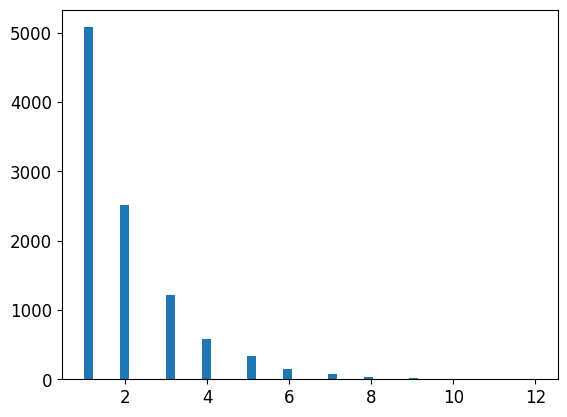

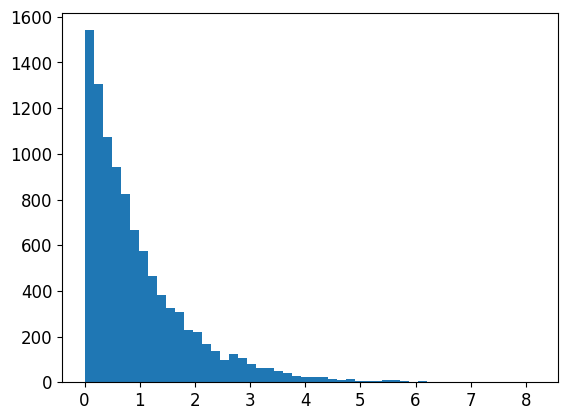

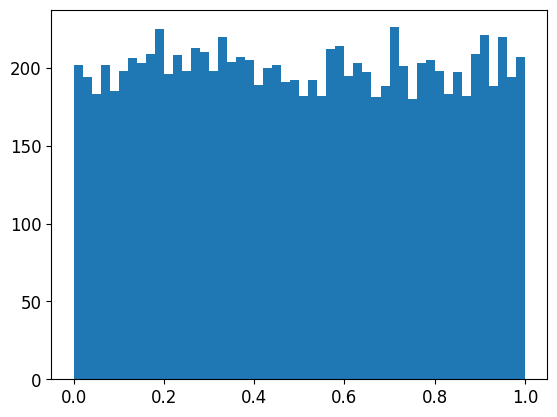

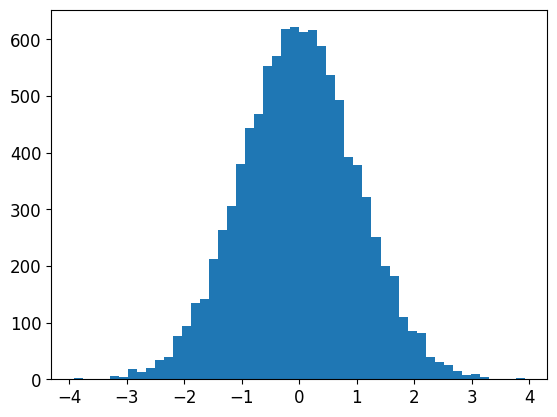

In [123]:
import matplotlib.pyplot as plt
from scipy.stats import geom, expon, norm, uniform

# 기하분포
geom_distrib=geom(0.5).rvs(10000, random_state=42)
# 지수분포
expon_distrib=expon().rvs(10000, random_state=42)
# 균등분포
uniform_distrib=uniform().rvs(10000)
# 정규분포
norm_distrib=norm().rvs(size=10000, random_state=42)

# 발생할 확률이 0.5인 사건이 몇 번 시도하면 발생하는가를 10,000번 실험한 결과
plt.hist(geom_distrib, bins=50)
plt.show()
# 특정 사건이 발생할 때까지 걸리는 시간을 10,000번 실험한 결과
plt.hist(expon_distrib, bins=50)
plt.show()
# 0과 1사의 실수를 임의로, 하지만 균등하게 10,000번 선택한 결과
plt.hist(uniform_distrib, bins=50)
plt.show()
# 무작위로 10,000개의 숫자를 선택한 결과. 단, 표준정규분포를 따라야 함.
plt.hist(norm_distrib, bins=50)
plt.show()

## 프로젝트

### 프로젝트 과제

아래의 세 가지 변환을 전처리 과정에 추가하면 훈련된 모델의 성능이 어떻게 얼마나 달라지는지 이전 모델과 비교하라.

__변환 1__

중간 소득과 중간 주택 가격 사이의 상관관계 그래프에서 확인할 수 있는 수평선에 위치한 데이터를 삭제한다.

__변환 2__

회귀 모델 훈련에 사용되는 12개의 특성 중에 세 개는 기존 9개의 특성을 조합하여 생성하였다. 12개의 특성 중에 중간 주택 가격과의 상관계수의 절댓값이 0.2 보다 작은 특성을 삭제한다.

주의사항: 특성 삭제는 훈련 세트 뿐만 아니라 테스트 세트에 대해서도 진행해야 한다. 특성이 다르면 동일한 모델을 적용할 수 없다.

__변환 3__

범주형 특성을 제외한 9개 특성별 히스토그램을 보면 일부 특성의 히스토그램이 좌우 비대칭이다.
(전문 용어로 __왜도__(skewness)가 0이 아닐 때 이런 분포가 발생한다.)
대표적으로 방의 총 개수(total_rooms), 침실 총 개수(total_bedrooms), 인구(population), 가구수(households), 중간소득(median_income) 등 다섯 개의 특성이 그렇다.
앞서 언급된 5개 특성 또는 일부에 대해 __로그 변환__을 적용한다.

### 프로젝트 진행 요령 및 힌트

1. 언급된 세 가지 변환을 우선 하나씩 구현하고 구현 가능한 변환만 접목할 것.
1. California Housing Price Prediction 프로젝트 관련 사이트를 살펴보고 비슷하게 진행할 것.
    - [캐글(kaggle) 참고 페이지 1](https://www.kaggle.com/khushboon/california-housing-price-prediction)
    - [캐글(kaggle) 참고 페이지 2](https://www.kaggle.com/suprabhatsk/california-housing-prices-prediction)
    - [캐글(kaggle) 참고 페이지 3](https://www.kaggle.com/subashdump/california-housing-price-prediction)
1. 지정된 특성값을 갖는 데이터 샘플 삭제 요령 참고 문서
    - [참고 1](https://www.codegrepper.com/code-examples/python/how+to+drop+specific+values+in+pandas)
    - [참고 2](https://chrisalbon.com/python/data_wrangling/pandas_dropping_column_and_rows/)
1. 상관관계 도표에서 수평선 위치 찾기
    - 방식 1: 중간 주택 가격의 히스토 그램에서 50만을 제외한 45만, 35만, 28만 근처에서의 수평선의 정확한 위치를 알아내기 위해 히스토그램을 언급된 값 근처의 구간으로 제한해서 히스토그램을 그리면 확인할 수 있을 것임. 다른 보다 편한 방식은 잘 모르겠음. 히스토그램을 제한하는 방식은 앞서 언급한 참고1, 2에서 소개한 방식 활용 가능
    - [valut_count() 메서드 활용](https://www.w3resource.com/pandas/series/series-value_counts.php)
1. 로그 변환: 넘파이의 log() 함수를 데이터프레임에 적용. 데이터프레임의 apply() 메서드 활용.
    - [참고 코드](https://nbviewer.jupyter.org/github/justmarkham/pandas-videos/blob/master/pandas.ipynb#30.-How-do-I-apply-a-function-to-a-pandas-Series-or-DataFrame%3F-%28video%29),
    [참고 코드 설명 동영상](https://www.youtube.com/watch?v=P_q0tkYqvSk&list=PL5-da3qGB5ICCsgW1MxlZ0Hq8LL5U3u9y&index=30)
    - 로그 변환 실전 활용 예제: [Housing Price Predictions Using Advanced Regression Techniques](https://github.com/atsigman/putb_nycdsa_kaggle/blob/master/kaggle_eda_version11_modeling.ipynb), `In [465]`, 즉 465번째 코드 셀(Testing if fixing Skewed Features Help) 참조

### 참고: 로그 변환

__로그 변환__(log transformation)은 수치 데이터에 로그(log) 함수를 적용하는 변환이며, 로그 변환이 이루어진 데이터의 분포는 보다 정규 분포에 가까워진다.
아래 그림은 왜도가 0이 아닌 분포(상단)에 로그 변환을 가했을 때 생성된 분포(하단)의 왜도가 훨씬 약화되어 정규분포에 가까워지는 것을 보여준다.
<img src="https://i.stack.imgur.com/7iSYs.png">

<그림 출처: [StackExchange](https://stats.stackexchange.com/questions/107610/what-is-the-reason-the-log-transformation-is-used-with-right-skewed-distribution)>




## 연습문제 해답

### 1.

질문: 서포트 벡터 머신 회귀(`sklearn.svm.SVR`)를 `kernel=“linear”`(하이퍼파라미터 `C`를 바꿔가며)나 `kernel=“rbf”`(하이퍼파라미터 `C`와 `gamma`를 바꿔가며) 등의 다양한 하이퍼파라미터 설정으로 시도해보세요. 지금은 이 하이퍼파라미터가 무엇을 의미하는지 너무 신경 쓰지 마세요. 최상의 `SVR` 모델은 무엇인가요?

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 30분 또는 그 이상 걸릴 수 있습니다.

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
        {'kernel': ['linear'], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
        {'kernel': ['rbf'], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]},
    ]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END ..............................C=10.0, kernel=linear; total time=   8.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.4s
[CV] END ..............................C=10.0, kernel=linear; total time=   7.2s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.5s
[CV] END ..............................C=10.0, kernel=linear; total time=   8.3s
[CV] END ..............................C=30.0, kernel=linear; total time=   7.4s
[CV] END ..............................C=30.0, kernel=linear; total time=   8.4s
[CV] END ..............................C=30.0, kernel=linear; total time=   7.3s
[CV] END ..............................C=30.0, kernel=linear; total time=   8.5s
[CV] END ..............................C=30.0, kernel=linear; total time=   8.4s
[CV] END .............................C=100.0, kernel=linear; total time=   7.2s
[CV] END .............................C=100.0, 

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error', verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [125]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(70286.61835383571)

`RandomForestRegressor`보다 훨씬 좋지 않네요. 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [126]:
grid_search.best_params_

{'C': 30000.0, 'kernel': 'linear'}

선형 커널이 RBF 커널보다 성능이 나은 것 같습니다. `C`는 테스트한 것 중에 최대값이 선택되었습니다. 따라서 (작은 값들은 지우고) 더 큰 값의 `C`로 그리드서치를 다시 실행해 보아야 합니다. 아마도 더 큰 값의 `C`에서 성능이 높아질 것입니다.

### 2.

질문: `GridSearchCV`를 `RandomizedSearchCV`로 바꿔보세요.

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 45분 또는 그 이상 걸릴 수 있습니다.

In [127]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

# expon(), reciprocal()와 그외 다른 확률 분포 함수에 대해서는
# https://docs.scipy.org/doc/scipy/reference/stats.html를 참고하세요.

# 노트: kernel 매개변수가 "linear"일 때는 gamma가 무시됩니다.
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring='neg_mean_squared_error',
                                verbose=2, random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.1s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.5s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   7.3s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.6s
[CV] END C=629.7823295913721, gamma=3.010121430917521, kernel=linear; total time=   8.6s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  14.0s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  14.2s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  14.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  14.7s
[CV] END C=26290.20646430022, gamma=0.9084469696321253, kernel=rbf; total time=  14.4s
[CV] END C=84.14107900575871, gamma=0.059838768608680676, 

RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785dc862c470>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x785dbbd885f0>,
                                        'kernel': ['linear', 'rbf']},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

최상 모델의 (5-폴드 교차 검증으로 평가한) 점수는 다음과 같습니다:

In [128]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

np.float64(54751.69009488048)

이제 `RandomForestRegressor`의 성능에 훨씬 가까워졌습니다(하지만 아직 차이가 납니다). 최상의 하이퍼파라미터를 확인해 보겠습니다:

In [129]:
rnd_search.best_params_

{'C': np.float64(157055.10989448498),
 'gamma': np.float64(0.26497040005002437),
 'kernel': 'rbf'}

이번에는 RBF 커널에 대해 최적의 하이퍼파라미터 조합을 찾았습니다. 보통 랜덤서치가 같은 시간안에 그리드서치보다 더 좋은 하이퍼파라미터를 찾습니다.

여기서 사용된 `scale=1.0`인 지수 분포를 살펴보겠습니다. 일부 샘플은 1.0보다 아주 크거나 작습니다. 하지만 로그 분포를 보면 대부분의 값이 exp(-2)와 exp(+2), 즉 0.1과 7.4 사이에 집중되어 있음을 알 수 있습니다.

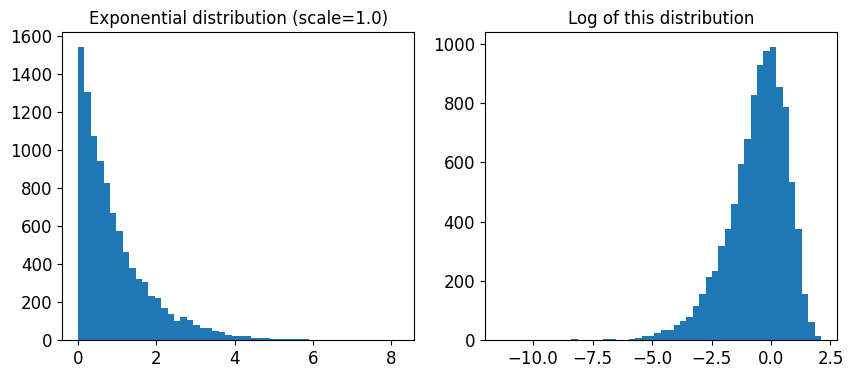

In [130]:
expon_distrib = expon(scale=1.)
samples = expon_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Exponential distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`C`에 사용된 분포는 매우 다릅니다. 주어진 범위안에서 균등 분포로 샘플링됩니다. 그래서 오른쪽 로그 분포가 거의 일정하게 나타납니다. 이런 분포는 원하는 축척(scale)이 정확이 무엇인지 모를 때 사용하면 좋습니다:

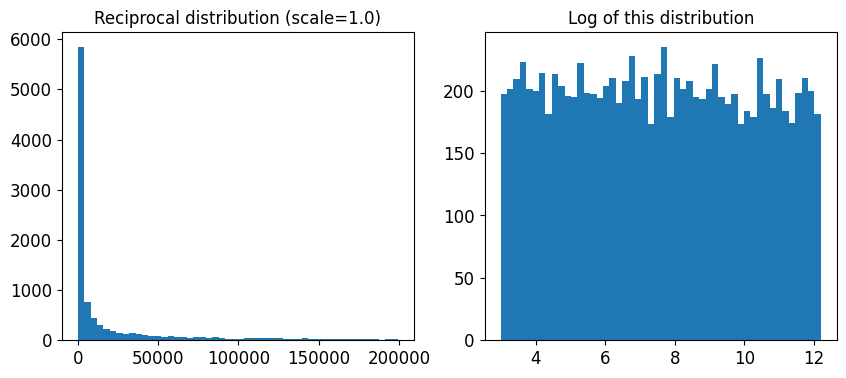

In [131]:
reciprocal_distrib = reciprocal(20, 200000)
samples = reciprocal_distrib.rvs(10000, random_state=42)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title("Reciprocal distribution (scale=1.0)")
plt.hist(samples, bins=50)
plt.subplot(122)
plt.title("Log of this distribution")
plt.hist(np.log(samples), bins=50)
plt.show()

`reciprocal()` 함수는 하이퍼파라미터의 축척에 대해 전혀 감을 잡을 수 없을 때 사용합니다(오른쪽 그래프에서 볼 수 있듯이 주어진 범위안에서 모든 값이 균등합니다). 반면 지수 분포는 하이퍼파라미터의 축척을 (어느정도) 알고 있을 때 사용하는 것이 좋습니다.

### 3.

질문: 가장 중요한 특성을 선택하는 변환기를 준비 파이프라인에 추가해보세요.

In [132]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

노트: 이 특성 선택 클래스는 이미 어떤 식으로든 특성 중요도를 계산했다고 가정합니다(가령 `RandomForestRegressor`을 사용하여). `TopFeatureSelector`의 `fit()` 메서드에서 직접 계산할 수도 있지만 (캐싱을 사용하지 않을 경우) 그리드서치나 랜덤서치의 모든 하이퍼파라미터 조합에 대해 계산이 일어나기 때문에 매우 느려집니다.

선택할 특성의 개수를 지정합니다:

In [133]:
k = 5

최상의 k개 특성의 인덱스를 확인해 보겠습니다:

In [134]:
top_k_feature_indices = indices_of_top_k(feature_importances, k)
top_k_feature_indices

array([ 0,  1,  7,  9, 12])

In [135]:
import numpy as np
np.array(attributes)[top_k_feature_indices]

array(['longitude', 'latitude', 'median_income', 'pop_per_hhold',
       'INLAND'], dtype='<U18')

최상의 k개 특성이 맞는지 다시 확인합니다:

In [136]:
sorted(zip(feature_importances, attributes), reverse=True)[:k]

[(np.float64(0.3790092248170967), 'median_income'),
 (np.float64(0.16570630316895876), 'INLAND'),
 (np.float64(0.10703132208204354), 'pop_per_hhold'),
 (np.float64(0.06965425227942929), 'longitude'),
 (np.float64(0.0604213840080722), 'latitude')]

좋습니다. 이제 이전에 정의한 준비 파이프라인과 특성 선택기를 추가한 새로운 파이프라인을 만듭니다:

In [137]:
preparation_and_feature_selection_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k))
])

In [138]:
housing_prepared_top_k_features = preparation_and_feature_selection_pipeline.fit_transform(housing)

처음 3개 샘플의 특성을 확인해 보겠습니다:

In [139]:
housing_prepared_top_k_features[0:3]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

최상의 k개 특성이 맞는지 다시 확인합니다:

In [140]:
housing_prepared[0:3, top_k_feature_indices]

array([[-0.94135046,  1.34743822, -0.8936472 ,  0.00622264,  1.        ],
       [ 1.17178212, -1.19243966,  1.292168  , -0.04081077,  0.        ],
       [ 0.26758118, -0.1259716 , -0.52543365, -0.07537122,  1.        ]])

성공입니다!  :)

### 4.

질문: 전체 데이터 준비 과정과 최종 예측을 하나의 파이프라인으로 만들어보세요.

In [141]:
prepare_select_and_predict_pipeline = Pipeline([
    ('preparation', full_pipeline),
    ('feature_selection', TopFeatureSelector(feature_importances, k)),
    ('svm_reg', SVR(**rnd_search.best_params_))
])

In [142]:
prepare_select_and_predict_pipeline.fit(housing, housing_labels)

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('attribs_adder',
                                                                   CombinedAttributesAdder()),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'total_rooms',
                                                   'total_bedrooms',
                                                   'population', 'households',
                                                   'median_income']),
                                                 ('cat', OneHotEncoder(...
                 TopFeatureSelector(feature_importances=array([6.96542523e-02, 6.04213840e-02, 4.21882202e-02, 1.52450557e-02,
       1.55545295e-02, 1.58491147e-02, 1.49346552e-02, 3.79009225e-01,
       5.47789150e-02, 1.07031322e-01, 4.82031213e-02, 6.79266007e-03,
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03]),
                                    k=5)),
                ('svm_reg',
                 SVR(C=np.float64(157055.10989448498),
                     gamma=np.float64(0.26497040005002437)))])

몇 개의 샘플에 전체 파이프라인을 적용해 보겠습니다:

In [143]:
some_data = housing.iloc[:4]
some_labels = housing_labels.iloc[:4]

print("Predictions:\t", prepare_select_and_predict_pipeline.predict(some_data))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 83384.49158095 299407.90439234  92272.03345144 150173.16199041]
Labels:		 [72100.0, 279600.0, 82700.0, 112500.0]


전체 파이프라인이 잘 작동하는 것 같습니다. 물론 예측 성능이 아주 좋지는 않습니다. `SVR`보다 `RandomForestRegressor`가 더 나은 것 같습니다.

### 5.

질문: `GridSearchCV`를 사용해 준비 단계의 옵션을 자동으로 탐색해보세요.

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 45분 또는 그 이상 걸릴 수 있습니다.

In [144]:
param_grid = [{
    'preparation__num__imputer__strategy': ['mean', 'median', 'most_frequent'],
    'feature_selection__k': list(range(1, len(feature_importances) + 1))
}]

grid_search_prep = GridSearchCV(prepare_select_and_predict_pipeline, param_grid, cv=5,
                                scoring='neg_mean_squared_error', verbose=2)
grid_search_prep.fit(housing, housing_labels)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   8.7s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=   9.0s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=mean; total time=  10.3s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=   7.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.2s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=median; total time=  10.3s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   7.5s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.2s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=  10.3s
[CV] END feature_selection__k=1, preparation__num__imputer__strategy=most_frequent; total time=   9.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   8.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  10.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  10.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=  10.2s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=mean; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=   8.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  10.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  10.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  10.1s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=median; total time=  10.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   8.9s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  10.7s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  10.6s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=   9.8s
[CV] END feature_selection__k=2, preparation__num__imputer__strategy=most_frequent; total time=  10.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=   9.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  10.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  10.9s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  10.1s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=mean; total time=  10.3s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   9.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  10.8s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  10.8s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=  10.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=median; total time=   9.9s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   9.0s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  10.9s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  10.7s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=  10.8s
[CV] END feature_selection__k=3, preparation__num__imputer__strategy=most_frequent; total time=   9.7s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=   9.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.5s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=mean; total time=  11.5s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=   9.2s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.0s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.7s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=median; total time=  11.6s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=   9.8s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.6s
[CV] END feature_selection__k=4, preparation__num__imputer__strategy=most_frequent; total time=  11.0s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=   9.3s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  11.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  11.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=mean; total time=  12.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=   9.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  12.0s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  11.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  11.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=median; total time=  11.8s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=   8.9s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.1s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  11.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  11.8s
[CV] END feature_selection__k=5, preparation__num__imputer__strategy=most_frequent; total time=  12.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  10.2s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.2s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.7s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.4s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=mean; total time=  12.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=   9.7s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.0s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.7s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=median; total time=  12.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  10.4s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.3s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.7s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.4s
[CV] END feature_selection__k=6, preparation__num__imputer__strategy=most_frequent; total time=  12.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  10.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.5s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  12.8s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=mean; total time=  13.7s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  11.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.6s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.5s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=median; total time=  13.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  11.0s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.3s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  12.9s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.1s
[CV] END feature_selection__k=7, preparation__num__imputer__strategy=most_frequent; total time=  13.3s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  16.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  15.4s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  15.4s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  15.8s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=mean; total time=  16.7s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  14.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  15.0s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  16.0s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  16.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=median; total time=  17.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  13.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  16.1s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  15.5s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  18.7s
[CV] END feature_selection__k=8, preparation__num__imputer__strategy=most_frequent; total time=  16.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  19.6s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  20.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  22.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  22.0s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=mean; total time=  21.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  18.1s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  23.3s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  22.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  20.2s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=median; total time=  23.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  15.7s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  23.9s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  21.9s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  19.5s
[CV] END feature_selection__k=9, preparation__num__imputer__strategy=most_frequent; total time=  22.3s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  25.8s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  26.1s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  22.2s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  26.9s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=mean; total time=  24.1s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  21.0s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  26.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  25.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  27.0s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=median; total time=  25.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  24.5s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  26.6s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  27.8s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  29.4s
[CV] END feature_selection__k=10, preparation__num__imputer__strategy=most_frequent; total time=  24.0s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  22.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  30.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  28.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  31.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=mean; total time=  27.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  22.1s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  28.2s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  24.7s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  31.1s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=median; total time=  27.4s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  28.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  28.4s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  30.0s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  30.9s
[CV] END feature_selection__k=11, preparation__num__imputer__strategy=most_frequent; total time=  30.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  24.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  33.8s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  32.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  32.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=mean; total time=  28.8s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  29.0s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  32.5s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  27.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  25.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=median; total time=  32.8s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  30.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  31.4s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  34.3s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  29.7s
[CV] END feature_selection__k=12, preparation__num__imputer__strategy=most_frequent; total time=  32.6s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  32.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  29.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  33.5s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  36.4s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=mean; total time=  28.5s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  31.1s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  35.4s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  28.5s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  35.3s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=median; total time=  35.2s


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
   

[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  31.8s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  28.0s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  33.2s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  30.9s
[CV] END feature_selection__k=13, preparation__num__imputer__strategy=most_frequent; total time=  29.3s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=   0.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  32.0s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  35.5s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  33.1s
[CV] END feature_selection__k=14, preparation__num__imputer__strategy=mean; total time=  35.5s
[CV] 

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
9 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/pipeline.py", line 654, in fit
    Xt = self._fit(X, y, routed_params, ra

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('attribs_adder',
                                                                                          CombinedAttributesAdder()),
                                                                                         ('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['longitude',
                                                                          'latitude',
                                                                          'housing_median_age',
                                                                          'total_rooms',
                                                                          'total_bedrooms',
                                                                          'population',
                                                                          'households',
                                                                          'median_inc...
       1.65706303e-01, 7.83480660e-05, 1.52473276e-03, 3.02816106e-03]),
                                                           k=5)),
                                       ('svm_reg',
                                        SVR(C=np.float64(157055.10989448498),
                                            gamma=np.float64(0.26497040005002437)))]),
             param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16],
                          'preparation__num__imputer__strategy': ['mean',
                                                                  'median',
                                                                  'most_frequent']}],
             scoring='neg_mean_squared_error', verbose=2)

In [145]:
grid_search_prep.best_params_

{'feature_selection__k': 1, 'preparation__num__imputer__strategy': 'mean'}

최상의 `Imputer` 정책은 `most_frequent`이고 거의 모든 특성이 유용합니다(16개 중 15개). 마지막 특성(`ISLAND`)은 잡음이 추가될 뿐입니다.